# Replication: Financial Intermediation, International Risk Sharing, and Reserve Currencies

## Autarky

In [1]:
mutable struct GertlerKiyotakiModel
    
    # utility function 
    ρ::Float64
    
    # stochastic process dY/Y
    μ::Float64
    σ::Float64

    # switching from financier to saver
    λ::Float64
    β::Float64
    δ::Float64
    
end

In [2]:
function GertlerKiyotakiModel(; ρ = 0.01, μ = 0.01, σ = 0.05, λ = 0.014, β = 1/3, δ = 0.004)
    GertlerKiyotakiModel(ρ, μ, σ, λ, β, δ)
end

GertlerKiyotakiModel

In [3]:
function initialize_state(m::GertlerKiyotakiModel; N_grid_length = 100)
    OrderedDict(:N => linspace(0.00001, 100., N_grid_length))
end

function initialize_y(m::GertlerKiyotakiModel, state)
    OrderedDict(:Q => fill(0.1, length(state[:N])), 
        :Ω => fill(0.1, length(state[:N])))
end

initialize_y (generic function with 1 method)

In [4]:
function (m::GertlerKiyotakiModel)(state, y)
    #unpack constants, state, current solution
    ρ = m.ρ; μ = m.μ; σ = m.σ; λ = m.λ; β = m.β; δ = m.δ
    N = state.N
    Q = y.Q; QN = y.QN; QNN = y.QNN; Ω = y.Ω; ΩN = y.ΩN; ΩNN = y.ΩNN;
    
    # interest rate
    rd = ρ + μ - σ^2
    
    # (dQ+Y)/Q
    μQ = (1 + Q * (μ + QN * (δ - μ - ρ)) + N * QN * (ρ - λ)) / (Q * (1 - QN)) + 
        (Q - N) * QN * σ^2 / (Q * (1 - QN)) + (Q - N)^2 * QNN * σ^2 / (2 * Q * (1 - QN)^3)
    σQ = (Q - N * QN) / (Q * (1 - QN)) * σ
    
    # dN/N process
    μN = rd - λ - μ + σ^2 + Q/N * (μQ - rd + δ - σ * σQ)
    σN = Q/N * σQ - σ
    
    # dΩ/Ω
    μΩ = ΩN * N / Ω * μN + 1/2 * ΩNN * N^2 / Ω * σN^2
    σΩ = ΩN * N / Ω * σN
    
    # PDE
    Qt = μQ - rd - σ * σQ + σΩ * σQ
    Ωt = λ * (1 - Ω) / Ω + μΩ - σ * σΩ
    
    return (Qt, Ωt), μN, tuple(:Q => Q, :Ω => Ω, :rd => rd)
end

In [56]:
function (m::GertlerKiyotakiModel)(state, y)
    #unpack constants, state, current solution
    ρ = m.ρ; μ = m.μ; σ = m.σ; λ = m.λ; β = m.β; δ = m.δ
    N = state.N
    Q = y.Q; QN = y.QN; QNN = y.QNN; Ω = y.Ω; ΩN = y.ΩN; ΩNN = y.ΩNN;
    
    # interest rate
    rd = ρ + μ - σ^2
    
    # (dQ+Y)/Q
    μQ = (1 + Q * (μ + QN * (δ - μ - ρ)) + N * QN * (ρ - λ)) / (Q * (1 - QN)) + 
        (Q - N) * QN * σ^2 / (Q * (1 - QN)) + (Q - N)^2 * QNN * σ^2 / (2 * Q * (1 - QN)^3)
    σQ = (Q - N * QN) / (Q * (1 - QN)) * σ
    
    # dN/N process
    μN = rd - λ - μ + σ^2 + Q/N * (μQ - rd + δ - σ * σQ)
    
    # PDE
    Qt = 2 * (-1 + QN) * (
        - (-1 + QN) * (1 + Q * (QN * δ - ρ) + N * QN * (-λ + ρ)) * Ω + (-N + Q) * (Q - N * QN) * σ^2 * ΩN
        ) / (
        (N - Q)^2 * σ^2 * Ω
        ) - QNN
    Ωt = (
        2 * (-1 + QN)^2 * λ * Ω * (-1 + Ω + N * ΩN) + 
        2 * ΩN * (- (-1 + QN) * ((-1 + QN) * (Q * δ + N * ρ) + (-N + Q) * σ^2) * Ω)
        ) / (
        (N - Q)^2 * σ^2 * Ω
        ) +
        (2 * ΩN * (-N + Q) * (Q - N * QN) * σ^2 * ΩN) / ((N - Q)^2 * σ^2 * Ω) - ΩNN
    
    return (Qt, Ωt), μN, tuple(:Q => Q, :Ω => Ω, :rd => rd)
end

In [5]:
using EconPDEs

m = GertlerKiyotakiModel()
state = initialize_state(m)
y0 = initialize_y(m, state)
y, result, distance = pdesolve(m, state, y0, iterations = 24, 
    inner_iterations = 100, Δ = 1e-5)

(iter, Δ, distance) = (1, 1.0e-5, 0.4990412627342443)
(iter, Δ, distance) = (2, 2.001997692186207e-5, 0.498048293274471)
(iter, Δ, distance) = (3, 8.023956470012935e-5, 0.49413850591438013)
(iter, Δ, distance) = (4, 0.0006469955734866024, 0.4662857354641777)
(iter, Δ, distance) = (5, 0.01097028372777056, 0.2917531623394432)
(iter, Δ, distance) = (6, 0.5610536551089322, 0.05942257595336877)
(iter, Δ, distance) = (7, 176.29843929872052, 0.0034043217747327264)
(iter, Δ, distance) = (8, 393893.9488954206, 1.079781567717812e-5)
(iter, Δ, distance) = (9, 3.1791715800311592e10, 3.3246399893834703e-12)


(DataStructures.OrderedDict(:Q=>[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0  …  100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0],:Ω=>[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), DataStructures.OrderedDict(:Q=>[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0  …  100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0],:Ω=>[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],:rd=>[0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175  …  0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175]), 3.3246399893834703e-12)

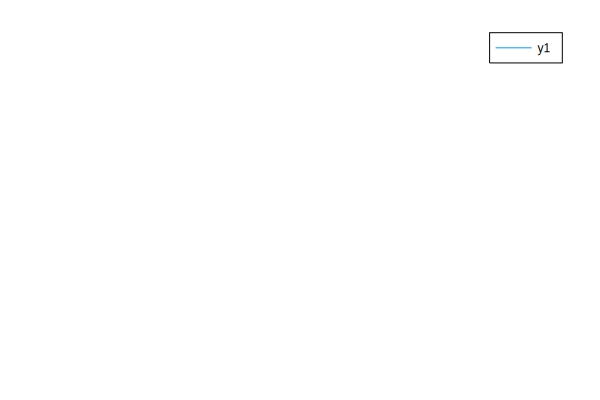

In [6]:
using Plots; gr();
plot(state[:N], result[:Q])

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW


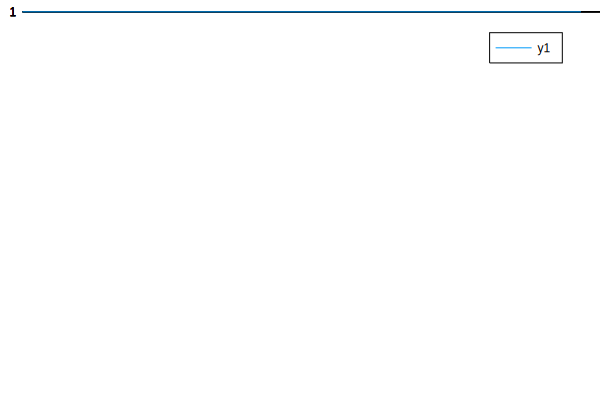

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW


In [7]:
plot(state[:N], result[:Ω])